# DIT863 Project

### Group: Chonkers

### Group members: Linus Holmberg, Noa Holmén, Anton Nordkvist

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
from wordcloud import STOPWORDS


### Preparing the data

In [2]:
# Load data
df = pd.read_csv("data/tweets_df.csv")

# See how many tweets per class
print(f"""Tweets/User:
{df.user_name.value_counts()}""")
# shape
print(f"Shape: {df.shape}")
# Nr of words
nr_of_words = df["text"].apply(lambda x: len(x.split())).sum()
print(f"Nr of words: {nr_of_words}")

print(df.head(2))

Tweets/User:
Donald Trump    43352
Elon Musk       34878
Random          20050
Name: user_name, dtype: int64
Shape: (98280, 4)
Nr of words: 1698924
   Unnamed: 0     user_name  \
0           0  Donald Trump   
1           1  Donald Trump   

                                                text  date  
0  Be sure to tune in and watch Donald Trump on L...  2009  
1  Donald Trump will be appearing on The View tom...  2009  


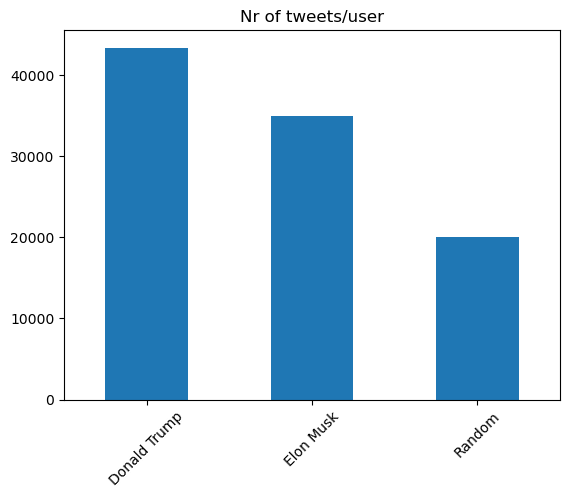

In [3]:
# Plot nr of tweets for each class
df.user_name.value_counts().plot(kind = "bar")
plt.title("Nr of tweets/user")
plt.xticks(rotation = 45)
plt.show()

In [4]:
# Remove first column
df = df.iloc[:,1:]

# Drop duplicates
df.drop_duplicates(subset = ["text"], keep = "first", inplace = True)

# See how many tweets per class
print(f"""Tweets/User:
{df.user_name.value_counts()}""")
# shape
print(f"Shape: {df.shape}")
# Nr of words
nr_of_words = df["text"].apply(lambda x: len(x.split())).sum()
print(f"Nr of words: {nr_of_words}")

print(df.head(2))

Tweets/User:
Donald Trump    43091
Random          18411
Elon Musk       15219
Name: user_name, dtype: int64
Shape: (76721, 3)
Nr of words: 1397322
      user_name                                               text  date
0  Donald Trump  Be sure to tune in and watch Donald Trump on L...  2009
1  Donald Trump  Donald Trump will be appearing on The View tom...  2009


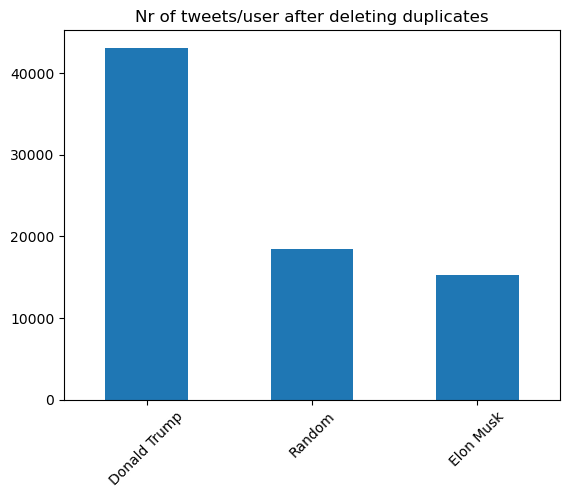

In [5]:
# Plot nr of tweets for each class
df.user_name.value_counts().plot(kind = "bar")
plt.title("Nr of tweets/user after deleting duplicates")
plt.xticks(rotation = 45)
plt.show()

In [6]:
""" BAD_SYMBOLS_RE Regex from - https://actsusanli.medium.com/"""
# Removes all symbols except those in the brackets
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #@]')
BAD_SYMBOLS = re.compile('[+-]')
AND_RE = re.compile("&amp;")

# Find tags and links in tweets
PERSON_TAG_SPACE = re.compile('@ ')
HASHTAG_SPACE = re.compile('# ')
PERSON_TAG = re.compile('@')
INTERNET_LINK = re.compile('http')

def clean_tweet(tweet):
    """
    Cleans the text in a tweet so it's easier to work with.

    Parameters:
    -----------
    tweet: a string

    Returns
    -------
    A cleaned string of a tweet
    """
    # Make the text lowercase
    tweet = tweet.lower()

    # Remove unwanted symbols
    tweet = AND_RE.sub("and", tweet)
    tweet = BAD_SYMBOLS.sub(" ", tweet)
    tweet = BAD_SYMBOLS_RE.sub("", tweet)

    # Catch user tags and links
    tweet = PERSON_TAG_SPACE.sub("@", tweet)
    tweet = HASHTAG_SPACE.sub("#", tweet)
    tweet = PERSON_TAG.sub('persontag', tweet)
    tweet = INTERNET_LINK.sub('internetlink', tweet)

    # Change every user tag and link to a specific word
    split_tweet = tweet.split()

    cleaned_tweet = ""

    for word in split_tweet:
        if word[0:9] == "persontag":
            word = "person_tag"
        if word[0:12] == "internetlink":
            word = "assigned_a_link"
        cleaned_tweet += word + " "

    return cleaned_tweet

In [7]:
# Clean text
df['clean_text'] = df['text'].apply(clean_tweet)

In [8]:
# Equal df - create a df with balanced classes 
equal_df = df.copy()
equal_df.drop(equal_df[equal_df['user_name'] == 'Random'].sample(random_state = 1,n = (equal_df.user_name.value_counts()[1] - equal_df.user_name.value_counts()[2])).index, inplace = True)
equal_df.drop(equal_df[equal_df['user_name'] == 'Donald Trump'].sample(random_state = 1, n = (equal_df.user_name.value_counts()[0] - equal_df.user_name.value_counts()[2])).index, inplace = True)

print(equal_df.user_name.value_counts())

Donald Trump    15219
Elon Musk       15219
Random          15219
Name: user_name, dtype: int64


In [9]:
def word_dict_builder(data, text_column, user_column):
    """
    Creates a nested dictionary with each word as the outer key. The inner key is the different users, and the value
    is the occurence of that word for each user.
    Calculates the number of words in every tweet.
    Creates a vocabulary containing every word.
    
    Parameters:
    -----------
    data: A dataframe
    text_column: Column in df that contains the text
    user_column: Column in df that contains the users
    """
    text_list = []
    user_list = []

    for index, rows in data.iterrows():
        text_list.append(rows[text_column].split())
        user_list.append(rows[user_column])

    # Append length of tweet
    tweet_length = [len(i) for i in text_list]

    words = []
    word_dict = {} 
    for index, meassage in enumerate(text_list):
        for word in meassage:
            
            if word not in word_dict.keys():
                word_dict[word] = {'Trump': 0, 'Musk': 0, 'Random' : 0 }

            if user_list[index] == 'Donald Trump':
                word_dict[word]['Trump'] += 1
                
            elif user_list[index] == 'Elon Musk':
                word_dict[word]['Musk'] += 1
            else:
                word_dict[word]['Random'] += 1 
            
            words.append(word)

    vocab = list(set(words))


    return word_dict, tweet_length, words, vocab

In [10]:
# Create the vocab
word_dict, tweet_length, word_list, vocab = word_dict_builder(equal_df, 'clean_text', 'user_name')

# Word count/tweet
equal_df['word_count'] = tweet_length

# Charachter length/tweet
equal_df['char_length'] = equal_df["clean_text"].apply(lambda x: len(x))

# Drop tweet in different language and only emojies. 
equal_df.drop(equal_df[(equal_df.word_count == 0)].index, inplace= True)

# Check if any differences
print(equal_df.user_name.value_counts())

Donald Trump    15219
Random          15219
Elon Musk       15193
Name: user_name, dtype: int64


### Hypothesis testing word count

In [11]:
import scipy.stats as stats
trump_wcount = np.array(equal_df.word_count[equal_df["user_name"] == "Donald Trump"])
musk_wcount = np.array(equal_df.word_count[equal_df["user_name"] == "Elon Musk"])
random_wcount = np.array(equal_df.word_count[equal_df["user_name"] == "Random"])

welch_two_t = stats.ttest_ind(trump_wcount, random_wcount, equal_var = False)
print(welch_two_t)

Ttest_indResult(statistic=35.914647977777484, pvalue=1.0820998915288188e-274)


In [12]:
import statsmodels.stats.oneway as sm
trump_wcount = np.array(equal_df.word_count[equal_df["user_name"] == "Donald Trump"])
musk_wcount = np.array(equal_df.word_count[equal_df["user_name"] == "Elon Musk"])
random_wcount = np.array(equal_df.word_count[equal_df["user_name"] == "Random"])

welch_anova = sm.anova_oneway((trump_wcount, musk_wcount, random_wcount), use_var = "unequal")
print(welch_anova)

statistic = 1180.8706120008983
pvalue = 0.0
df = (2.0, 27140.357868212424)
df_num = 2.0
df_denom = 27140.357868212424
nobs_t = 45631.0
n_groups = 3
means = [19.59386293 13.33127098 15.85682371]
nobs = [15219. 15193. 15219.]
vars_ = [131.71511807 125.67112383  33.06249303]
use_var = unequal
welch_correction = True
tuple = (1180.8706120008983, 0.0)


### Modelling

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

In [14]:
# Divide into train/test
X_train, X_test, y_train, y_test = train_test_split(
    equal_df['clean_text'], equal_df['user_name'], test_size = 0.10, random_state=1)
    
print(f"Training data size: {X_train.shape}")
print(f"Test data size: {X_test.shape}")

Training data size: (41067,)
Test data size: (4564,)


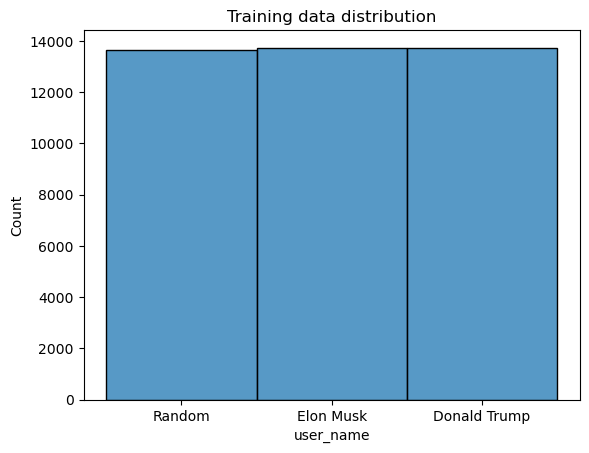

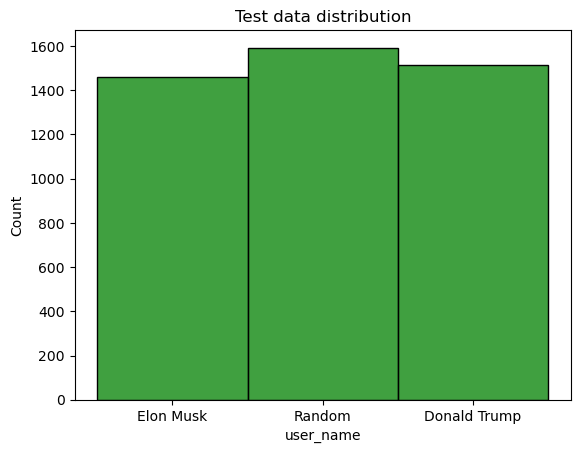

In [15]:
# Plot distribution of tweets per training/val/test
sns.histplot(y_train).set(title="Training data distribution")
plt.show()
sns.histplot(y_test, color="green").set(title="Test data distribution")
plt.show()

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# MnB count

mnb_count_pipe = Pipeline([
               ('count', CountVectorizer(min_df = 2)), #Get the counts of words
               ('clf', MultinomialNB()), # Create MNB object
              ])


mnb_count_params = [{"clf__alpha":[0.1,0.2,0.3,0.4,0.5,1]}]

gs_mnb_count = GridSearchCV(mnb_count_pipe, param_grid = mnb_count_params,
 scoring = "f1_macro", cv = 5)

gs_mnb_count.fit(X_train, y_train)

In [ ]:
# MnB tfidf

mnb_tfidf_pipe = Pipeline([
               ('tfidf', TfidfVectorizer(min_df = 2)), #Get the counts of words
               ('model', MultinomialNB()), # Create MNB object
              ])

mnb_tfidf_params = [{"model__alpha":[0.1,0.2,0.3,0.4,0.5,1]}]

gs_mnb_tfidf = GridSearchCV(mnb_tfidf_pipe, param_grid = mnb_tfidf_params,
 scoring = "accuracy", cv = 5)

gs_mnb_tfidf.fit(X_train, y_train)

In [ ]:
# SVM model with count
svm_count_pipe = Pipeline([
               ('count', CountVectorizer(min_df = 2)), #Get the counts of words
               ('model', SVC(kernel = "rbf", C = 3)), # Create MNB object
              ])

svm_count_params = [{"model__kernel":['linear', 'poly', 'rbf', 'sigmoid']}]

gs_svm_count = GridSearchCV(svm_count_pipe, param_grid = svm_count_params,
 scoring = "accuracy", cv = 5)

gs_svm_count.fit(X_train, y_train)

In [ ]:
# SVM model with tfidf
svm_tfidf_pipe = Pipeline([
               ('tfidf', TfidfVectorizer(min_df = 2)), #Get the counts of words
               ('model', SVC(kernel = "rbf", C = 3)), # Create MNB object
              ])

svm_tfidf_params = [{"model__gamma":["scale", "auto"]}]

gs_svm_tfidf = GridSearchCV(svm_tfidf_pipe, param_grid = svm_tfidf_params,
 scoring = "accuracy", cv = 5)

gs_svm_tfidf.fit(X_train, y_train)

CV

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
# SVM model
svm_clf = Pipeline([
    ("tfidf", TfidfVectorizer(min_df = 2)),
    ("clf", SVC(kernel = "rbf", C = 3, gamma = "scale"))])

svm_scores = cross_validate(svm_clf, X_train, y_train, cv = 10, scoring =("accuracy", "f1_macro"), verbose = 2)

print(svm_scores)


In [ ]:
# MnB model
mnb_clf = Pipeline([
    ("count", CountVectorizer(min_df = 2)),
    ("clf", MultinomialNB(alpha = 0.4))])

mnb_scores = cross_validate(mnb_clf, X_train, y_train, cv = 10, scoring =("accuracy", "f1_macro"), verbose = 2)

print(mnb_scores)

### Comparing classifiers


In [ ]:
import scipy.stats as stats

In [ ]:
# Save f1 score in separate arrays
mnb_f1 = mnb_scores["test_f1_macro"]
svm_f1 = svm_scores["test_f1_macro"]

# Test if sample follows a Gaussian distribution
f1_diffs = mnb_f1 - svm_f1
norm = stats.normaltest(f1_diffs)

# Run paired t-test on our two samples
paired_t = stats.ttest_rel(mnb_f1, svm_f1)
print(f"Paired t-test results: {paired_t}")

# Test if sample follows a Gaussian distribution
f1_diffs = mnb_f1 - svm_f1
norm = stats.normaltest(f1_diffs)
print(f"Normaltest results: {norm}")

### Run model on test data

In [ ]:
# SVM model with tfidf
svm_tfidf = Pipeline([
               ('tfidf', TfidfVectorizer(min_df = 2)),
               ('clf', SVC(C = 3, kernel = "rbf", gamma = "scale")),
              ])
svm_tfidf.fit(X_train, y_train)

In [ ]:
svm_tfidf_pred = svm_tfidf.predict(X_test)
print(f" Accuracy: {accuracy_score(y_test, svm_tfidf_pred)}")
print(classification_report(y_test, svm_tfidf_pred))

# Create Confusion Matrix
cf = confusion_matrix(y_test, svm_tfidf_pred, labels=["Donald Trump", "Elon Musk", "Random"])

In [ ]:
#Nice fixed confusion matrix
categories = ["Donald Trump", "Elon Musk", "Random"]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
group_count = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
labels = [f"{v1}{v2}".strip() for v1,v2 in zip(group_count, group_percentages)]
labels = np.asarray(labels).reshape(cf.shape[0],cf.shape[1])

sns.heatmap(cf, xticklabels=categories, yticklabels=categories, annot = labels, fmt='', cmap = 'Greens').set(
    title = "SVM classifier")
plt.show()

### Random plots

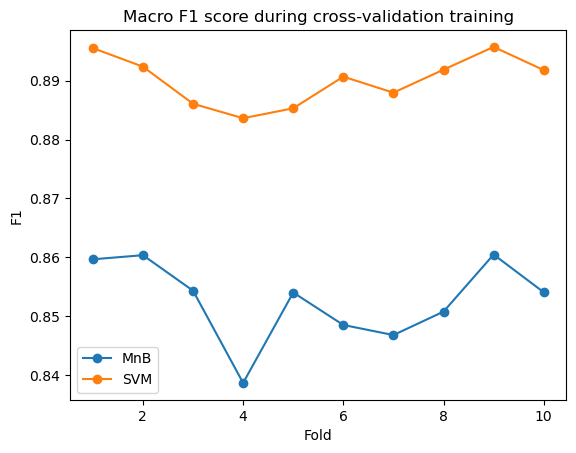

In [16]:
# Training plots

mnb_a = np.array(([0.85967238, 0.86037133, 0.85434323, 0.83867523, 0.85402918,
       0.84851857, 0.84680671, 0.85078446, 0.86047961, 0.85407185]))

svm_a = np.array(([0.89554769, 0.89239322, 0.88609212, 0.88363462, 0.88532334,
       0.89069622, 0.88797521, 0.89188236, 0.89574541, 0.89181039]))

x = np.arange(1,11)

fig, ax = plt.subplots()
ax.plot(x, mnb_a, marker = "o", label = "MnB")
ax.plot(x, svm_a, marker = "o", label = "SVM")
ax.legend()
plt.title("Macro F1 score during cross-validation training")
plt.xlabel("Fold")
plt.ylabel("F1")

plt.show()

In [17]:
# Test if sample differs from normal distirbution
f1_diffs = mnb_a - svm_a

norm = stats.normaltest(f1_diffs)

print(norm)

NormaltestResult(statistic=1.6915005867584796, pvalue=0.42923518504617997)


c:\Users\Anton Nordkvist\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


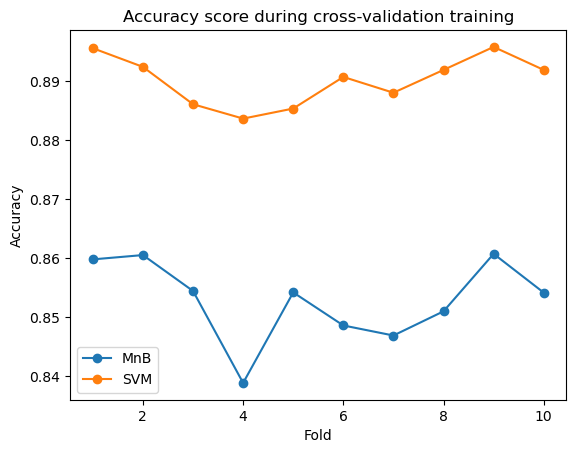

In [18]:
# Training plots

mnb_a = np.array(([0.85975164, 0.8604821 , 0.85439494, 0.83881178, 0.85415145,
       0.84855125, 0.84684685, 0.85094983, 0.86069167, 0.85411593]))

svm_a = np.array(([0.89554419, 0.89237887, 0.88604821, 0.88361334, 0.88531775,
       0.89067446, 0.8879961 , 0.89186556, 0.8957623 , 0.89186556]))

x = np.arange(1,11)

fig, ax = plt.subplots()
ax.plot(x, mnb_a, marker = "o", label = "MnB")
ax.plot(x, svm_a, marker = "o", label = "SVM")
ax.legend()
plt.title("Accuracy score during cross-validation training")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

plt.show()

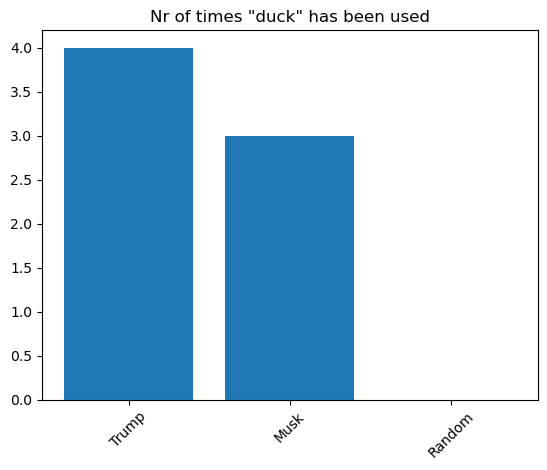

In [20]:
def word_plot(word_dict, word):
    """
    Plot the frequency of a specific word over all classes.
    """
    df_gb = word_dict[word]
    names = list(df_gb.keys())
    values = list(df_gb.values())

    plt.bar(range(len(df_gb)), values , tick_label=names)
    plt.title(f'Nr of times "{word}" has been used')
    plt.xticks(rotation = 45)
    plt.show()

# Plot the given word
word_plot(word_dict, "duck")

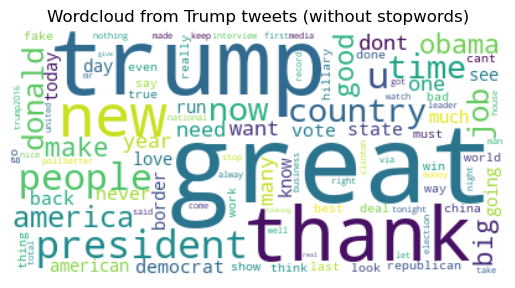

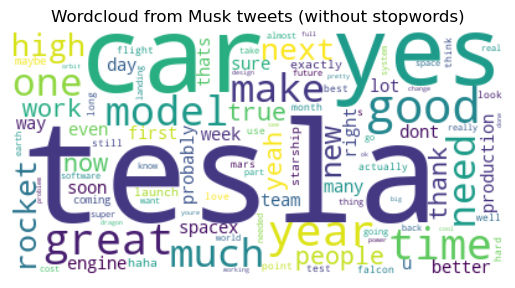

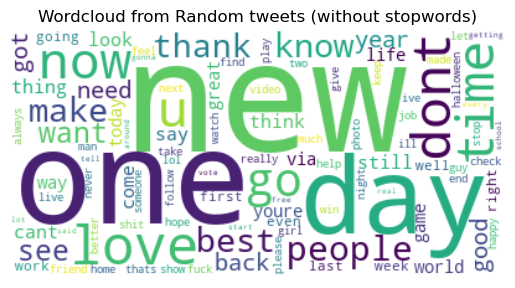

In [21]:
""" Word Clouds"""
# From original df, not equal_df
trump_df = equal_df[equal_df["user_name"] == "Donald Trump"]
musk_df = equal_df[equal_df["user_name"] == "Elon Musk"]
random_df = equal_df[equal_df["user_name"] == "Random"]

tweets_trump = " ".join(word for word in trump_df.clean_text)
tweets_musk = " ".join(word for word in musk_df.clean_text)
tweets_random = " ".join(word for word in random_df.clean_text)

stop_words = ["assigned_a_link", "person_tag", "will", "im"] + list(STOPWORDS)

wordcloud = WordCloud(collocations = False,background_color = "white", max_words = 100,
stopwords = stop_words).generate(tweets_trump)
plt.axis("off")
plt.imshow(wordcloud, interpolation = "bilinear")
plt.title("Wordcloud from Trump tweets (without stopwords)")
plt.show()

wordcloud = WordCloud(collocations = False, background_color = "white", max_words = 100,
stopwords = stop_words).generate(tweets_musk)
plt.axis("off")
plt.imshow(wordcloud, interpolation = "bilinear")
plt.title("Wordcloud from Musk tweets (without stopwords)")
plt.show()

wordcloud = WordCloud(collocations = False, background_color = "white", max_words = 100,
stopwords = stop_words).generate(tweets_random)
plt.axis("off")
plt.imshow(wordcloud, interpolation = "bilinear")
plt.title("Wordcloud from Random tweets (without stopwords)")
plt.show()

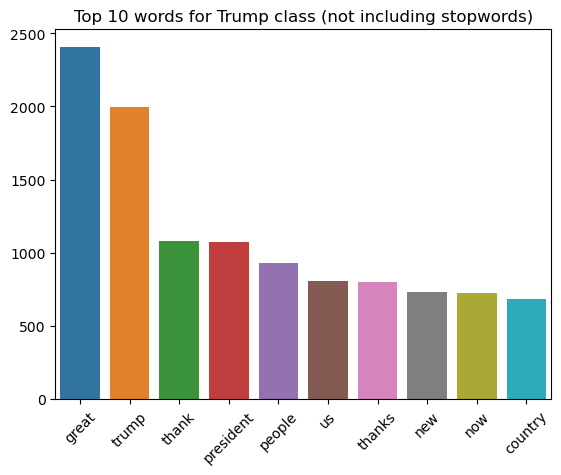

In [22]:
# Plot trumps top 10 words
trump_dict, tweet_length, trump_word_list, trump_vocab = word_dict_builder(trump_df, 'clean_text', 'user_name')
# remove stopwords
trump_word_list = [word for word in trump_word_list if word not in stop_words]
# Create counter
trump_c = Counter(trump_word_list)

# Break out words and counts in separate lists
trump_top10 = trump_c.most_common(10)
trump_top10_words = [trump_top10[i][0] for i in range(10)]
trump_top10_counts = [trump_top10[i][1] for i in range(10)]

# Plot top 10 words
sns.barplot(x = trump_top10_words, y = trump_top10_counts).set(
    title = "Top 10 words for Trump class (not including stopwords)")
plt.xticks(rotation = 45)

plt.show()

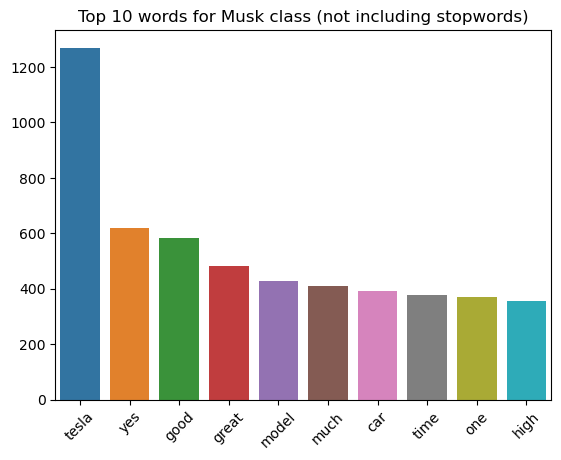

In [23]:
# Plot musk top 10 words
musk_dict, tweet_length, musk_word_list, musk_vocab = word_dict_builder(musk_df, 'clean_text', 'user_name')
# remove stopwords
musk_word_list = [word for word in musk_word_list if word not in stop_words]
# Create counter
musk_c = Counter(musk_word_list)

# Break out words and counts in separate lists
musk_top10 = musk_c.most_common(10)
musk_top10_words = [musk_top10[i][0] for i in range(10)]
musk_top10_counts = [musk_top10[i][1] for i in range(10)]

# Plot top 10 words
sns.barplot(x = musk_top10_words, y = musk_top10_counts).set(
    title = "Top 10 words for Musk class (not including stopwords)")
plt.xticks(rotation = 45)

plt.show()

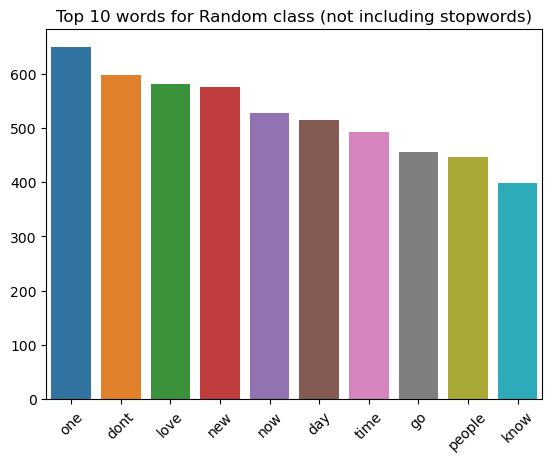

In [24]:
# Plot random class top 10 words
random_dict, tweet_length, random_word_list, random_vocab = word_dict_builder(random_df, 'clean_text', 'user_name')
# remove stopwords
random_word_list = [word for word in random_word_list if word not in stop_words]
# Create counter
random_c = Counter(random_word_list)

# Break out words and counts in separate lists
random_top10 = random_c.most_common(10)
random_top10_words = [random_top10[i][0] for i in range(10)]
random_top10_counts = [random_top10[i][1] for i in range(10)]

# Plot top 10 words
sns.barplot(x = random_top10_words, y = random_top10_counts).set(
    title = "Top 10 words for Random class (not including stopwords)")
plt.xticks(rotation = 45)

plt.show()

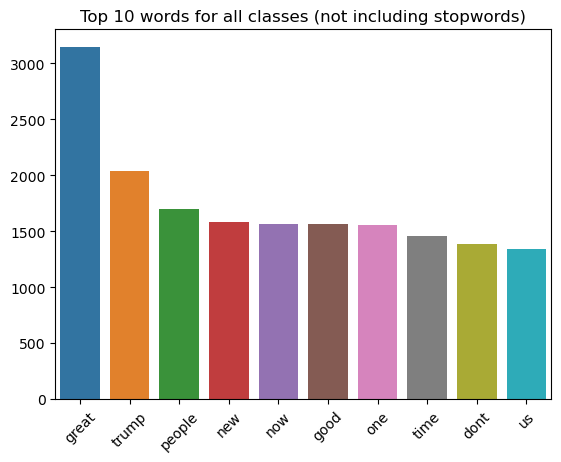

In [25]:
# Plot random class top 10 words
#random_dict, tweet_length, random_word_list, random_vocab = word_dict_builder(random_df, 'clean_text', 'user_name')
# remove stopwords
random_word_list = [word for word in word_list if word not in stop_words]
# Create counter
random_c = Counter(random_word_list)

# Break out words and counts in separate lists
random_top10 = random_c.most_common(10)
random_top10_words = [random_top10[i][0] for i in range(10)]
random_top10_counts = [random_top10[i][1] for i in range(10)]

# Plot top 10 words
sns.barplot(x = random_top10_words, y = random_top10_counts).set(
    title = "Top 10 words for all classes (not including stopwords)")
plt.xticks(rotation = 45)

plt.show()

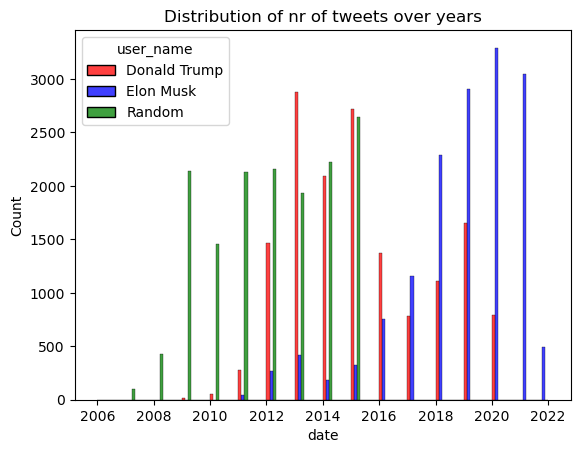

In [26]:
# Plot distribution of dates per class
colors = ["red", "blue", "green"]
sns.histplot(x = "date", data = equal_df, hue = "user_name", multiple = "dodge", palette = colors).set(
    title = "Distribution of nr of tweets over years")

plt.show()

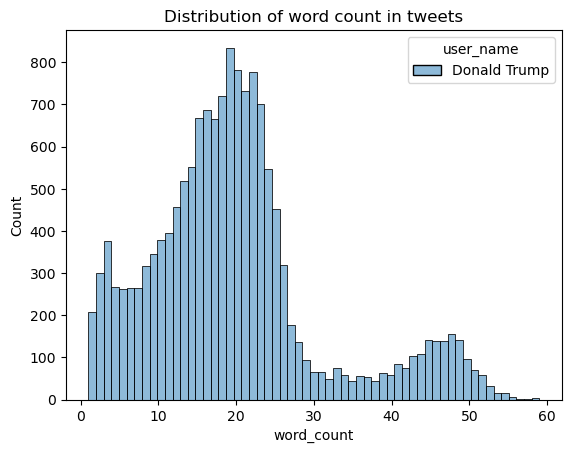

In [27]:
# Plot class word counts
sns.histplot(x = "word_count", data = trump_df, hue = "user_name", bins = 59).set(
    title = "Distribution of word count in tweets")

plt.show()